# **Generate Titles from the Abstract**

Advanced Topics in Machine Learning - Group P1_C

Produced by:
- Catarina Monteiro up202105279
- Diogo Mendes up202108102
- Gonçalo Brochado up202106090

Our objective with this approach is to generate precise and informative titles from paper abstracts, improving both paper identification and the accuracy of topic-specific searches. To achieve this, we will utilize two models: a baseline model and a specialized pre-trained model designed for title generation. By comparing their performance, we aim to identify the most effective model for implementation, optimizing both relevance and retrieval effectiveness for enhanced research accessibility.

## **Dependencies**

In [ ]:
!pip install datasets
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=r

## **Libraries**

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import evaluate
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt

## **Data**

The data for the project was retrieved using the Hugging Face datasets library, specifically loading the Arxiv abstracts dataset. This dataset includes metadata from scientific papers, such as titles, abstracts, author names, and categories, and provides a comprehensive base for training and evaluating models for title generation, abstract generation, and category prediction.

In [ ]:
ds = load_dataset("gfissore/arxiv-abstracts-2021")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

arxiv-abstracts.jsonl.gz:   0%|          | 0.00/940M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1999486 [00:00<?, ? examples/s]

In [ ]:
ds['train'].column_names

['id',
 'submitter',
 'authors',
 'title',
 'comments',
 'journal-ref',
 'doi',
 'abstract',
 'report-no',
 'categories',
 'versions']

In [ ]:
ds['train']['title']

['Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
 'Sparsity-certifying Graph Decompositions',
 'The evolution of the Earth-Moon system based on the dark matter field\n  fluid model',
 'A determinant of Stirling cycle numbers counts unlabeled acyclic\n  single-source automata',
 'From dyadic $\\Lambda_{\\alpha}$ to $\\Lambda_{\\alpha}$',
 'Bosonic characters of atomic Cooper pairs across resonance',
 'Polymer Quantum Mechanics and its Continuum Limit',
 'Numerical solution of shock and ramp compression for general material\n  properties',
 'The Spitzer c2d Survey of Large, Nearby, Insterstellar Clouds. IX. The\n  Serpens YSO Population As Observed With IRAC and MIPS',
 'Partial cubes: structures, characterizations, and constructions',
 'Computing genus 2 Hilbert-Siegel modular forms over $\\Q(\\sqrt{5})$ via\n  the Jacquet-Langlands correspondence',
 'Distribution of integral Fourier Coefficients of a Modular Form of Half\n  Integral Weight Mo

In [ ]:
# Limit the first 100 samples for testing
abstracts = ds['train']['abstract'][:100]
val_titles = ds['train']['title'][:100]

## **Test Models**

This next section of code implements functions to evaluate the quality of the titles generated by comparing them to actual titles using key metrics: **ROUGE**, **BLEU**, and **METEOR**. Each metric offers a unique perspective on similarity. 
- **ROUGE** focuses on n-gram overlap, ideal for summarization tasks;
- **BLEU** measures precision of word matches, common in translation tasks;
- **METEOR** considers semantic nuances, like synonymy and word order. 

A more detailed explanation will be given afertwards.

In [ ]:
def rouge_scores(generated_titles, val_titles): #ROUGE
  rouge = evaluate.load('rouge')
  results = rouge.compute(predictions=generated_titles, references=val_titles)
  return results

def blue_score(generated_titles,val_titles): #BLEU
  bleu = evaluate.load("bleu")
  results = bleu.compute(predictions=generated_titles, references=[[title] for title in val_titles])
  return results

def meteor_score(generated_titles, val_titles):  # METEOR
  meteor = evaluate.load("meteor")
  results = meteor.compute(predictions=generated_titles, references=val_titles)
  return results

def teste_model(abstracts, val_titles, tokenizer, model): #Test Model
  generated_titles = []

  for abstract in abstracts:
    inputs = tokenizer(f"""Generate Title: {abstract}""", return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    title = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    generated_titles.append(title[0])

  rouge = rouge_scores(generated_titles, val_titles)
  blue = blue_score(generated_titles, val_titles)
  meteor = meteor_score(generated_titles, val_titles)

  return rouge , blue, meteor, generated_titles

## **Base Model (Flan-T5)**

For Flan-T5, we started by manually testing the different model variations, comparing the Small, Base, Large, and XL versions. The larger versions were computationally unfeasible to use given the resources available to us.

#### Flan-T5 - Small


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
r_s, b_s, m_s, gen_titles_flan_s = teste_model(abstracts, val_titles, tokenizer, model)
print(r_s)
print(b_s)
print(m_s)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


{'rouge1': 0.3171834906812326, 'rouge2': 0.1749775766560315, 'rougeL': 0.2984765889406976, 'rougeLsum': 0.30043789188233383}
{'bleu': 0.06123610383284968, 'precisions': [0.24727272727272728, 0.10881542699724518, 0.052547770700636945, 0.027932960893854747], 'brevity_penalty': 0.7724547730159402, 'length_ratio': 0.7947976878612717, 'translation_length': 825, 'reference_length': 1038}
{'meteor': 0.2675192493813021}


#### Flan-T5 - Base


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
r_b, b_b, m_b, gen_titles_flan_b = teste_model(abstracts, val_titles, tokenizer, model)
print(r_b)
print(b_b)
print(m_b)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'rouge1': 0.35096833200344546, 'rouge2': 0.19145113808433228, 'rougeL': 0.3295495163419826, 'rougeLsum': 0.3354090257674698}
{'bleu': 0.04355378317172681, 'precisions': [0.2857142857142857, 0.10839160839160839, 0.048625792811839326, 0.021108179419525065], 'brevity_penalty': 0.5800489066751474, 'length_ratio': 0.6473988439306358, 'translation_length': 672, 'reference_length': 1038}
{'meteor': 0.2820499648044657}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Flan-T5 - Large


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
r_l, b_l, m_l, gen_titles_flan_l = teste_model(abstracts, val_titles, tokenizer, model)
print(r_l)
print(b_l)
print(m_l)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'rouge1': 0.40562479503567384, 'rouge2': 0.22524765552325496, 'rougeL': 0.3722381031544705, 'rougeLsum': 0.3761210632990466}
{'bleu': 0.07992092050367379, 'precisions': [0.2907268170426065, 0.1318051575931232, 0.07692307692307693, 0.04609218436873747], 'brevity_penalty': 0.7402614238491025, 'length_ratio': 0.7687861271676301, 'translation_length': 798, 'reference_length': 1038}
{'meteor': 0.3433540893770944}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Flan-T5 - XL

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-xl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
r_xl, b_xl, m_xl, gen_titles_flan_xl = teste_model(abstracts, val_titles, tokenizer, model)
print(r_xl)
print(b_xl)
print(m_xl)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'rouge1': 0.40094698556083774, 'rouge2': 0.22756805881061504, 'rougeL': 0.36814152908192305, 'rougeLsum': 0.3741670227698102}
{'bleu': 0.06793218123323175, 'precisions': [0.3163538873994638, 0.12848297213622292, 0.06593406593406594, 0.03803131991051454], 'brevity_penalty': 0.6760955197417521, 'length_ratio': 0.7186897880539499, 'translation_length': 746, 'reference_length': 1038}
{'meteor': 0.33173442014263443}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Callidior/Bert2bert-base-arxiv-titlegen

After preparing and testing with a baseline model, we then use a pre-trained model specifically designed for this task to compare results and select the most effective one for implementation.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Callidior/bert2bert-base-arxiv-titlegen")
model = AutoModelForSeq2SeqLM.from_pretrained("Callidior/bert2bert-base-arxiv-titlegen")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/262k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
r_callidior, b_callidior, m_callidior, gen_titles_flan_callidior = teste_model(abstracts, val_titles, tokenizer, model)
print(r_callidior)
print(b_callidior)
print(m_callidior)

{'rouge1': 0.431179224487122, 'rouge2': 0.2534149018168552, 'rougeL': 0.3936644193106781, 'rougeLsum': 0.403586265898085}
{'bleu': 0.09802344146100571, 'precisions': [0.2518315018315018, 0.11290322580645161, 0.06950672645739911, 0.04671717171717172], 'brevity_penalty': 1.0, 'length_ratio': 1.0520231213872833, 'translation_length': 1092, 'reference_length': 1038}
{'meteor': 0.35236925895433047}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## **Results**

#### **ROUGE, BLEU e METEOR metrics**

- **Rouge** :
  - **Rouge-1**: Measures the overlap of individual words, ensuring that the title contains key scientific terms.
  - **Rouge-2**: Evaluates word pairs, important for creating fluent and relevant sequences in the title.
  - **Rouge-L**: Measures the longest common sequence of words, essential for ensuring that the title follows a logical and cohesive structure.
- **Bleu** :
  - **Bleu Score**: Assesses the exact word sequence, ensuring precision and clarity—important qualities for scientific titles.
  - **Precision 1-Gram**: Measures the presence of individual keywords, ensuring the accurate selection of the most relevant technical terms.

- **METEOR**: Focuses on semantics, capturing the main idea of the abstract, which is essential for the title to accurately reflect the article’s content.


These measures are essential for evaluating the accuracy, structure, and semantics of the generated titles. Together, they enable a comprehensive analysis, ensuring that the model uses appropriate terms (Rouge-1, Precision 1-Gram) and creates a fluent text sequence (Rouge-2, Bleu Score), while also reflecting the core meaning of the scientific content (Rouge-L, METEOR).

In this use case, these metrics help assess whether the model is generating titles that are precise, informative, and relevant to the respective article.

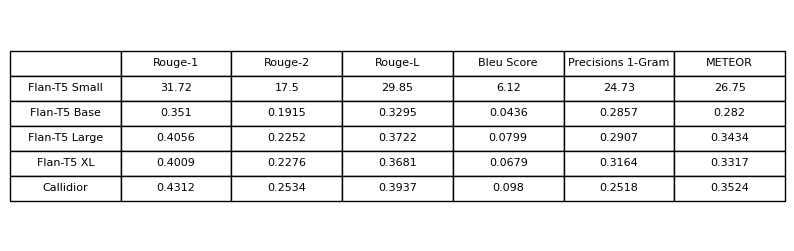

In [ ]:
data = [
    ["", "Rouge-1", "Rouge-2", "Rouge-L", "Bleu Score", "Precisions 1-Gram", "METEOR"],  
    ["Flan-T5 Small", 31.72, 17.50, 29.85, 6.12, 24.73, 26.75],
    ["Flan-T5 Base", 0.3510, 0.1915, 0.3295, 0.0436, 0.2857, 0.2820],
    ["Flan-T5 Large", 0.4056, 0.2252, 0.3722, 0.0799, 0.2907, 0.3434],
    ["Flan-T5 XL", 0.4009, 0.2276, 0.3681, 0.0679, 0.3164, 0.3317],
    ["Callidior", 0.4312, 0.2534, 0.3937, 0.0980, 0.2518, 0.3524],
]

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis("off")  

table = ax.table(cellText=data, loc="center", cellLoc="center", colLoc="center")

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(2, 1.5)

plt.show()

By first analyzing the variations of Flan-T5, we observed that the XL model delivered the best results, as expected. Although it is larger than the other models, it performs quickly.



As anticipated, the model we used that was specifically trained for title generation from abstracts achieved the highest performance. It excels in capturing vocabulary, cohesion, structure, and meaning from reference titles, making it the preferred model for the final version of the project.

However, these results may be subjective since the comparison was made against existing titles. Given that title generation is inherently subjective and benefits from human evaluation, we reviewed a sample of titles and incorporated this assessment to select the model Callidior/bert2bert-base-arxiv-titlegen.